<a href="https://colab.research.google.com/github/rdwn354/E-Blink_classification/blob/main/re_create_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# dataset
path_dataset = "/content/gdrive/MyDrive/datasets/Dataset"

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Function to load images and labels from the dataset
def load_data_from_folders(path_dataset):
    images = []
    labels = []
    for label, folder in enumerate(["open", "close"]):
        folder_path = os.path.join(path_dataset, folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            # Read the image and resize it to a fixed size (e.g., 224x224)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (224, 224))  # Adjust the size to 224x224 pixels
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
# Load images and labels from the dataset
X, y = load_data_from_folders(path_dataset)

In [ ]:


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize pixel values to range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Define the dimensions and channels of your input images
img_height, img_width, channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

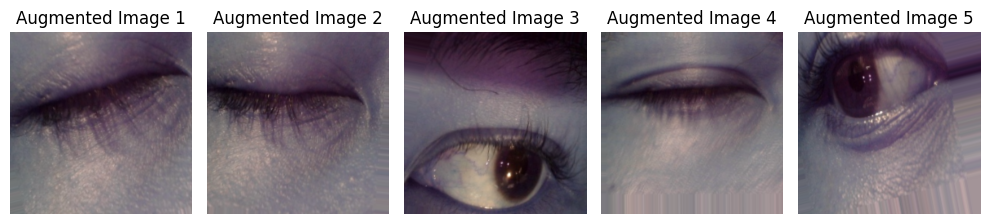

In [ ]:
import matplotlib.pyplot as plt

# Generate augmented images
augmented_images = []
num_augmented_images = 5  # Number of augmented images to generate
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=1):
    augmented_image = cv2.cvtColor(X_batch[0], cv2.COLOR_BGR2RGB)
    augmented_images.append(X_batch[0])
    if len(augmented_images) >= num_augmented_images:
        break

# Display augmented images
plt.figure(figsize=(10, 5))
for i, image in enumerate(augmented_images):
    plt.subplot(1, len(augmented_images), i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Augmented Image {i + 1}')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channels)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Add dropout with rate 0.5
    layers.Dense(1, activation='sigmoid')
])

# Print model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 173056)           

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model using data augmentation
train_generator = datagen.flow(X_train, y_train, batch_size=32)
history = model.fit(train_generator, steps_per_epoch=len(X_train)//32, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
30/30 [==============================] - 15s 396ms/step - loss: 0.7523 - accuracy: 0.6631 - val_loss: 0.3902 - val_accuracy: 0.9091
Epoch 2/10
30/30 [==============================] - 12s 395ms/step - loss: 0.4424 - accuracy: 0.8011 - val_loss: 0.2376 - val_accuracy: 0.9091
Epoch 3/10
30/30 [==============================] - 12s 397ms/step - loss: 0.2679 - accuracy: 0.8930 - val_loss: 0.1147 - val_accuracy: 0.9752
Epoch 4/10
30/30 [==============================] - 12s 391ms/step - loss: 0.1872 - accuracy: 0.9326 - val_loss: 0.0498 - val_accuracy: 0.9917
Epoch 5/10
30/30 [==============================] - 13s 412ms/step - loss: 0.1055 - accuracy: 0.9594 - val_loss: 0.0278 - val_accuracy: 0.9876
Epoch 6/10
30/30 [==============================] - 12s 398ms/step - loss: 0.0922 - accuracy: 0.9701 - val_loss: 0.0144 - val_accuracy: 0.9959
Epoch 7/10
30/30 [==============================] - 12s 388ms/step - loss: 0.0970 - accuracy: 0.9658 - val_loss: 0.0338 - val_accuracy: 0.9917

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Accuracy: {test_accuracy}')

8/8 [==============================] - 0s 21ms/step - loss: 0.0227 - accuracy: 0.9876
Test Accuracy: 0.9876033067703247


8/8 [==============================] - 0s 19ms/step


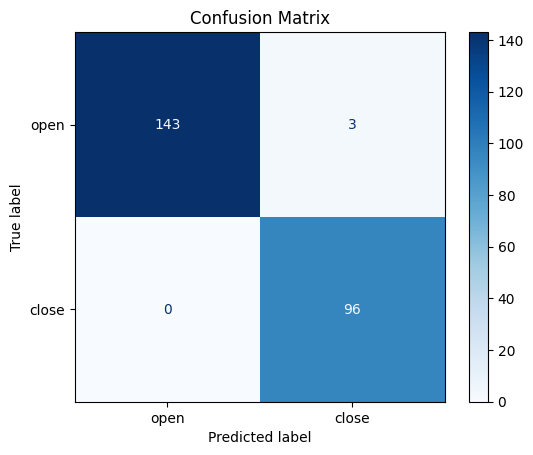

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert labels back to original format for confusion matrix calculation
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
y_test_binary = y_test

# Calculate confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["open", "close"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Save the model
model.save('blink_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Upload user's photo
uploaded = files.upload()

# Load the trained model
model = load_model("/content/blink_detection_model.h5")

# Function to preprocess the uploaded image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Get the uploaded image path
image_path = next(iter(uploaded))

# Preprocess the image
input_image = preprocess_image(image_path)

# Perform prediction
prediction = model.predict(input_image)

# Convert prediction to class label
class_label = "open" if prediction < 0.5 else "close"

# Display prediction result
print("Prediction:", class_label)


Saving Screenshot 2024-03-27 014929.png to Screenshot 2024-03-27 014929.png
1/1 [==============================] - 0s 67ms/step
Prediction: open
